<a href="https://colab.research.google.com/github/Mikcl/CellTransformer/blob/wip-no-repeat/Cells_are_Transformers_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install linear-attention-transformer
!pip install einops

  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-cp37-none-any.whl size=2905 sha256=b1c2dd206a5b1f53864ae455920769a07852d662ef5a692c2aa9c800fdca9003
  Stored in directory: /root/.cache/pip/wheels/cd/f8/93/25b60e319a481e8f324dcb1871aff818eb0c8143ed20b732b4
  Created wheel for product-key-memory: filename=product_key_memory-0.1.10-cp37-none-any.whl size=3072 sha256=df25e594fa6120502e9e84e182ced9f798606bc7d39673eecdc46ec94f114a77
  Stored in directory: /root/.cache/pip/wheels/6d/e0/3b/fd3111a4fac652ed014ccfd4757754f006132723985e229419
Successfully built axial-positional-embedding product-key-memory


In [2]:
import os
import base64
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from IPython.display import Image, HTML, clear_output
import tqdm

import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import matplotlib.pylab as plt
import glob

import torch.optim as optim

from linear_attention_transformer import LinearAttentionTransformerLM
from linear_attention_transformer.autoregressive_wrapper import AutoregressiveWrapper

from einops import rearrange

clear_output()

In [3]:
#@title Cellular Automata Parameters
CHANNEL_N = 4        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

# 👁, 🦎
TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Growing" #@param ["Growing"] # "Persistent", "Regenerating"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [4]:
#@title Transformer Token Details
TOKEN_OFFSET = 2
NUM_TOKENS = 257 + TOKEN_OFFSET
ENC_SEQ_LEN = 9 * CHANNEL_N
DEC_SEQ_LEN = CHANNEL_N

In [5]:
#@title Tranformer Hyperparameters 

EPOCHS = 401 #int(1e3)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
# GENERATE_EVERY  = 100   # For visual results during training. . 

In [6]:
#@title Helpers 

def to_rgba(x):
  return x[:,:4,:,:]

def to_rgb(x):
  return x[:,:3,:,:]

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

def plot_loss(loss_log):
  plt.figure(figsize=(10, 4))
  plt.title('Loss history (log10)')
  plt.plot(np.log10(loss_log), '.', alpha=0.1)
  plt.show()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


In [7]:
#@title Load image utils. 

# Returns h,w,c image where c=RGBA
def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  # img = np.float32(img)
  # return img

  # ASSUME THIERS
  img = np.float32(img)/255.0
  # premultiply normalised RGB by Alpha
  img[..., :3] *= img[..., 3:]
  img = img*255.0
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png'%code
  return load_image(url)

In [8]:
#@title To Device
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)  

In [9]:
#@title Load Emoji
target_img = load_emoji(TARGET_EMOJI)

In [10]:
p = TARGET_PADDING
target_img_tensor = torch.from_numpy(target_img)

# (72,72,4)
pad_target = torch.nn.functional.pad(target_img_tensor, pad=(0,0,p,p,p,p), mode='constant', value=0)
h, w = pad_target.shape[:2]

# (CHANNEL_N, 72, 72)
seed = np.zeros([CHANNEL_N, h, w], np.float32)
seed[3:, h//2, w//2] = 255

pad_target = pad_target.permute(2, 0, 1)

In [11]:
pad_target = pad_target.to(device)


In [31]:
#@title Masking Utils
IMAGE_BATCH_SIZE = 1 #number of images to concurrently train on. 
LIVE_MIN = 0

# Applied on default/non-tokenized values
def get_living_mask(x, rate=LIVE_MIN, k=3):
  alpha = x[:, 3:4, :, :]
  p = 1 if k > 1 else 0
  return torch.nn.functional.max_pool2d(input=alpha, kernel_size=k, stride=1, padding=p) > rate

# 3d tensor as boolean. rate = 0 before, k =3
alive_target_mask = get_living_mask(pad_target[None,...]/255.0, rate=0.1, k=1)

loss_target_mask = get_living_mask(pad_target[None,...]/255.0, rate=0.1, k=1)
loss_target = ((pad_target/255.0) * loss_target_mask.float().bool().long())

def cleaned_x_long(x, bool_mask):
  return  (x * bool_mask.float().bool().long()).long()

def t_loss_f(x, clean=False):
    x = x[:,:,:,:]

    x = x if not clean else cleaned_x_long(x,loss_target_mask)
    # ls = nn.MSELoss()
    # err = ls(x[0]/255.0, pad_target.long()/255.0).cpu().detach().numpy()
    return np.mean(torch.square((x/255.0)-loss_target).cpu().detach().numpy(), axis=1)


def loss_f(x, clean=False):
    x = x[:,:,:,:]


    # ls = nn.MSELoss()
    # err = ls(x[0]/255.0, pad_target.long()/255.0).cpu().detach().numpy()
    return np.mean(torch.square((x/255.0)-(pad_target/255.0)).cpu().detach().numpy(), axis=1)


def get_dilatied_mask(x):
  # Returns x dilated mask as FloatType 
  output = x.sum(-3) > 0
  output = output.type(torch.FloatTensor)
  kernel = torch.tensor([[1,1,1],[1,1,1],[1,1,1]]).type(torch.FloatTensor)
  dilated = torch.nn.functional.conv2d(output[None,...], kernel[None, None, ...].expand(1, -1, -1, -1), groups=1, padding=1)
  return dilated

def get_living_target(x):
  living_mask = get_living_mask(x)

  # print('SUM OF 1s', torch.sum(torch.flatten(living_mask)))
  living_target_mask = (living_mask & alive_target_mask)
  living_target = pad_target[None,...] * living_target_mask.float()
  living_target = living_target[0]
  return living_target

def mask_target(mask):
  '''
    mask - tensor: 2D - Float

    returns - tensor: 4D - T
  '''
  # returns 4d tensor. 
  target_batch = pad_target[None, ...] * mask
  return target_batch


In [13]:
#@title Define Model
def tokenize(x):
  return (x + 2).long()

def detokenize(x):
  return (x - 2).long()

def percieve(x):
  # x - 4d tensor - N, C, H, W
  _,_,h,w = x.shape
  padded_x = torch.nn.functional.pad(x, pad=(1,1,1,1), mode='constant', value=0)
  stacked_image = torch.cat(
      [padded_x[:,:,i:i+h, j:j+w]  for j in range(3) for i in range(3)]
      ,1
  )
  return stacked_image


# instantiate model
enc = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 512*2,
    heads = 8,
    depth = 6,
    max_seq_len = ENC_SEQ_LEN,
    one_kv_head = True,
    return_embeddings = True
).to(device)

dec = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 512*2,
    heads = 8,
    depth = 6,
    causal = True,
    blindspot_size = 1,
    max_seq_len = DEC_SEQ_LEN,
    one_kv_head = True,
    receives_context = True
).to(device)

dec = AutoregressiveWrapper(dec)





In [14]:
#@title Load Saved Model Instead
LOAD_MODEL = False
enc_path = './EncA.pth'
dec_path = './A.pth'
if (LOAD_MODEL):
  enc = torch.load(enc_path)
  enc.eval()
  dec = torch.load(dec_path)
  dec.eval()


In [15]:
optim = torch.optim.Adam([*enc.parameters(), *dec.parameters()], lr=LEARNING_RATE)

In [16]:
#@title Dataset Generation Helpers. 
SENTENCES = int(alive_target_mask.shape[2] * alive_target_mask.shape[3])

class CellTraining(Dataset):
    def __init__(self, X, Y):
        self.src = X
        self.tgt = Y
        assert X.shape[0] == Y.shape[0], 'Dataset X and Y not of same length'

        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.TGT_MASK = torch.ones(b, DEC_SEQ_LEN).bool()

        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        tgt = self.tgt[idx]
        src_mask = self.SRC_MASK[idx]
        tgt_mask = self.TGT_MASK[idx] 
        return src.to(device), tgt.to(device), src_mask.to(device), tgt_mask.to(device)


class CellEvaluating(Dataset):
    def __init__(self, X):
        self.src = X
        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        src_mask = self.SRC_MASK[idx]
        return src.to(device), src_mask.to(device)



def get_start_tokens(number_of_sentences):
    return torch.ones((number_of_sentences, 1)).long().to(device)

def image_to_sentences(x):
  '''
    ## maps a 3D tensor of shape (c, h, w) to a 2D tensor of (h*w, c)
    these are known as sentences or 'patches' of size one
  '''
  return rearrange(x,'c h w -> (h w) c')


def sentences_to_image(x, height, width):
  '''
    ## maps a 2D tesnor of shape (h*w, c) to image/3D tensor shape of (c, h, w)
    inverse of image_to_sentence
    height: int - image dimension
    width: int - image dimension
  '''
  return rearrange(x, '(h w) (p1 p2 c) -> c (h p1) (w p2)', p1 =1, p2 =1, h=height, w=width)

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def visualize_batched(x, c=4):
  x = x[:,:c,:,:].cpu().numpy()
  vis1 = np.hstack(np.transpose(x, (0,2,3,1)))
  plt.imshow(vis1)
  plt.show()


def get_X_values(x, mask=None):
  # X values
  percieved_images = percieve(x)
  X_img = percieved_images[0]

  # TODO - optional mask here? 
  X_img = X_img if mask==None else (X_img[None,...] * mask)[0]

  X_seq_un_clean = image_to_sentences(X_img)
  valid_instances = (torch.tensor(X_seq_un_clean).bool().float().sum(dim=-1) != 0).nonzero().flatten().long()

  X_seq_cleaned = X_seq_un_clean[valid_instances]

  X_seq = tokenize(X_seq_cleaned)
  return valid_instances, X_seq


# X - 4d tensor - maybe move this
def get_input_values(x):
  step_output_float_mask = get_dilatied_mask(x).to(device)

  valid_instances, X_seq = get_X_values(x)

  return step_output_float_mask, valid_instances, X_seq

def get_update_values(x, step_float, seen_float):
  training_float = (step_float.bool() ^ seen_float.bool()).float()
  seen_float = (training_float.bool() | seen_float.bool()).float()

  # TODO - use training float to extract valid instances
  valid_instances, X_seq = get_X_values(x, training_float)

  return training_float, valid_instances, X_seq, seen_float

def get_X0():
  x0 = np.repeat(seed[None,...], IMAGE_BATCH_SIZE, 0)
  x0 = torch.Tensor(x0).to(device)
  return x0

def create_training_dataset():
  x0 = get_X0()
  x = x0
  prev_N = None
  seen_float = (get_living_mask(x).float() * 0).to(device);

  x_values = []
  y_values = []

  while (prev_N != 0):

    step_output_float_mask, valid_instances, X_seq = get_input_values(x)

    u_step_output_float_mask, u_valid_instances, u_X_seq, seen_float = get_update_values(x, step_output_float_mask, seen_float)
    N = len(u_valid_instances)
    prev_N = N
    if (N != 0):
      training_float_mask, valid_instances, X_seq = u_step_output_float_mask, u_valid_instances, u_X_seq
    else:
      training_float_mask = step_output_float_mask

    y_target = mask_target(training_float_mask.bool().float())[0]

    # Prefix
    prefix = get_start_tokens(X_seq.shape[0])

    # Y valyes from target
    y_seq_un_cleaned = image_to_sentences(y_target)
    y_seq_cleaned = y_seq_un_cleaned[valid_instances]
    y_seq = tokenize(y_seq_cleaned)
    Y_seq = torch.cat([prefix, y_seq], 1)

    # Add X_seq, Y_seq to a dataset
    x_values.append(X_seq)
    y_values.append(Y_seq)

    x = mask_target(step_output_float_mask.bool().float()).to(device)

  X_seqs = torch.cat(x_values, 0)
  Y_seqs = torch.cat(y_values, 0)
  training_dataset = CellTraining(X_seqs, Y_seqs)
  return training_dataset



In [17]:
training_dataset = create_training_dataset()
print('LEN DATASET', len(training_dataset))

LEN DATASET 2030


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


In [18]:
#@title Generate Method { vertical-output: true}

def generate(encoder, decoder, x, EVAL_STEPS):
  encoder.eval(), decoder.eval()

  for step in tqdm.auto.tqdm(range(EVAL_STEPS), mininterval=1., desc='evaluation step'):
    output_seq = torch.zeros(SENTENCES, CHANNEL_N).long().to(device)

    step_output_float_mask, update_instances, X_seq = get_input_values(x)

    update_instances = update_instances

    dataset = CellEvaluating(X_seq)
    eval_data_loader = DataLoader(dataset=dataset, batch_size=SENTENCE_BATCH, shuffle=False)
    
    generated= torch.zeros(X_seq.shape[0], CHANNEL_N).long().to(device)

    for batch_i , (src, src_mask) in enumerate(eval_data_loader):
      start_tokens = (torch.ones((src.shape[0], 1)) * 1).long().to(device)

      context = encoder(src)
      
      sample = decoder.generate(start_tokens, DEC_SEQ_LEN , context = context)
      predicted_cells = sample[:, - CHANNEL_N: ]
      s = batch_i*SENTENCE_BATCH
      
      locations = torch.arange(s,s+predicted_cells.shape[0])

      generated[locations] = predicted_cells

    output_seq[update_instances] = detokenize(generated)
    output_img = sentences_to_image(output_seq, x.shape[2], x.shape[3])
    
    x = output_img[None,...]

  return x


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


training epochs:   0%|          | 0/400 [00:00<?, ?it/s]

LEN DATASET 2030




training epochs:   0%|          | 1/400 [00:13<1:31:33, 13.77s/it]

training epochs:   0%|          | 2/400 [00:27<1:31:56, 13.86s/it]

training epochs:   1%|          | 3/400 [00:42<1:33:05, 14.07s/it]

training epochs:   1%|          | 4/400 [00:57<1:34:22, 14.30s/it]

training epochs:   1%|▏         | 5/400 [01:11<1:34:31, 14.36s/it]

training epochs:   2%|▏         | 6/400 [01:25<1:34:04, 14.33s/it]

training epochs:   2%|▏         | 7/400 [01:40<1:33:32, 14.28s/it]

training epochs:   2%|▏         | 8/400 [01:54<1:33:12, 14.27s/it]

training epochs:   2%|▏         | 9/400 [02:08<1:33:13, 14.31s/it]

training epochs:   2%|▎         | 10/400 [02:23<1:33:18, 14.36s/it]

training epochs:   3%|▎         | 11/400 [02:37<1:33:07, 14.36s/it]

training epochs:   3%|▎         | 12/400 [02:52<1:32:52, 14.36s/it]

training epochs:   3%|▎         | 13/400 [03:06<1:32:29, 14.34s/it]

training epochs:   4%|▎         | 14/400 [03:20<1:32:09, 14.33s/it]

training epochs:   4%|▍         | 15/400 



 LOSS: -1.9323155879974365


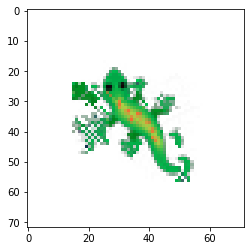

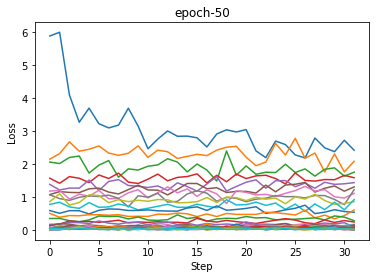

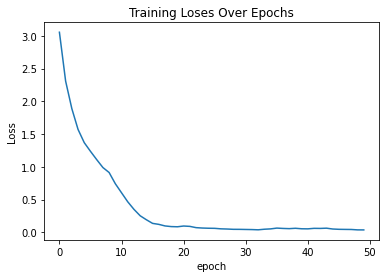

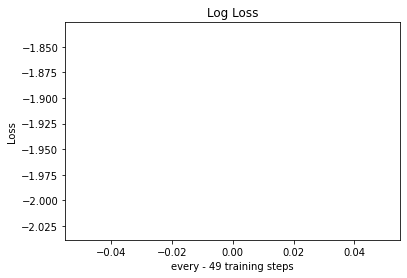



training epochs:  12%|█▎        | 50/400 [12:33<2:28:52, 25.52s/it]

training epochs:  13%|█▎        | 51/400 [12:48<2:08:52, 22.16s/it]

training epochs:  13%|█▎        | 52/400 [13:02<1:54:57, 19.82s/it]

training epochs:  13%|█▎        | 53/400 [13:16<1:45:05, 18.17s/it]

training epochs:  14%|█▎        | 54/400 [13:31<1:38:03, 17.00s/it]

training epochs:  14%|█▍        | 55/400 [13:45<1:33:00, 16.18s/it]

training epochs:  14%|█▍        | 56/400 [13:59<1:29:25, 15.60s/it]

training epochs:  14%|█▍        | 57/400 [14:13<1:26:50, 15.19s/it]

training epochs:  14%|█▍        | 58/400 [14:28<1:25:03, 14.92s/it]

training epochs:  15%|█▍        | 59/400 [14:42<1:23:43, 14.73s/it]

training epochs:  15%|█▌        | 60/400 [14:56<1:22:43, 14.60s/it]

training epochs:  15%|█▌        | 61/400 [15:11<1:22:00, 14.52s/it]

training epochs:  16%|█▌        | 62/400 [15:25<1:21:29, 14.47s/it]

training epochs:  16%|█▌        | 63/400 [15:39<1:21:04, 14.44s/it]

training epochs:  16%|█▌        



 LOSS: -2.082287073135376


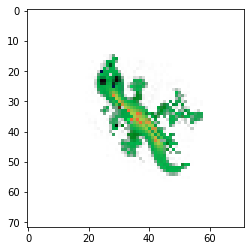

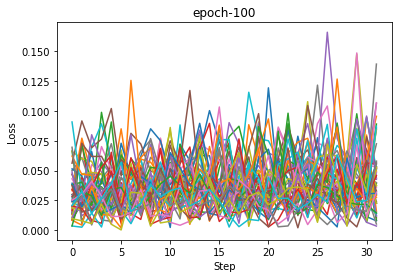

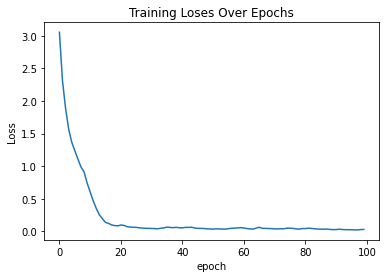

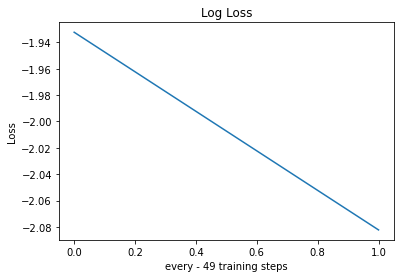



training epochs:  25%|██▌       | 100/400 [25:06<2:07:06, 25.42s/it]

training epochs:  25%|██▌       | 101/400 [25:20<1:49:57, 22.06s/it]

training epochs:  26%|██▌       | 102/400 [25:34<1:38:00, 19.73s/it]

training epochs:  26%|██▌       | 103/400 [25:49<1:29:37, 18.11s/it]

training epochs:  26%|██▌       | 104/400 [26:03<1:23:42, 16.97s/it]

training epochs:  26%|██▋       | 105/400 [26:17<1:19:31, 16.18s/it]

training epochs:  26%|██▋       | 106/400 [26:32<1:16:34, 15.63s/it]

training epochs:  27%|██▋       | 107/400 [26:46<1:14:26, 15.25s/it]

training epochs:  27%|██▋       | 108/400 [27:00<1:12:51, 14.97s/it]

training epochs:  27%|██▋       | 109/400 [27:15<1:11:41, 14.78s/it]

training epochs:  28%|██▊       | 110/400 [27:29<1:10:47, 14.65s/it]

training epochs:  28%|██▊       | 111/400 [27:43<1:10:03, 14.54s/it]

training epochs:  28%|██▊       | 112/400 [27:58<1:09:29, 14.48s/it]

training epochs:  28%|██▊       | 113/400 [28:12<1:09:02, 14.43s/it]

training epochs:  



 LOSS: -3.042404890060425


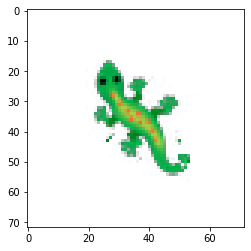

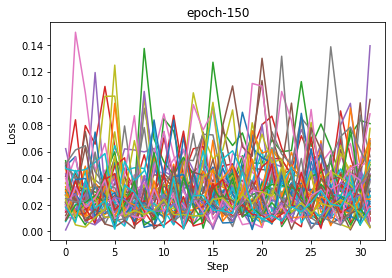

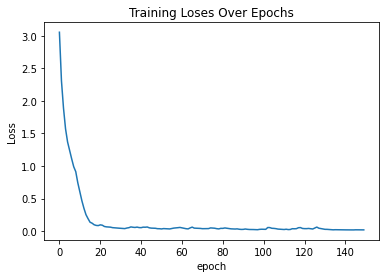

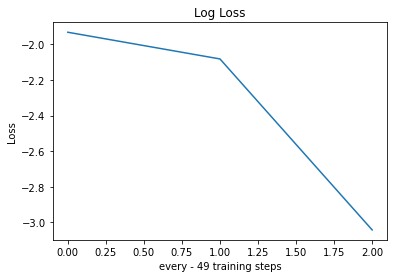



training epochs:  38%|███▊      | 150/400 [37:35<1:41:59, 24.48s/it]

training epochs:  38%|███▊      | 151/400 [37:49<1:28:51, 21.41s/it]

training epochs:  38%|███▊      | 152/400 [38:04<1:19:44, 19.29s/it]

training epochs:  38%|███▊      | 153/400 [38:18<1:13:20, 17.82s/it]

training epochs:  38%|███▊      | 154/400 [38:32<1:08:47, 16.78s/it]

training epochs:  39%|███▉      | 155/400 [38:47<1:05:30, 16.04s/it]

training epochs:  39%|███▉      | 156/400 [39:01<1:03:07, 15.52s/it]

training epochs:  39%|███▉      | 157/400 [39:15<1:01:21, 15.15s/it]

training epochs:  40%|███▉      | 158/400 [39:30<1:00:02, 14.89s/it]

training epochs:  40%|███▉      | 159/400 [39:44<59:03, 14.70s/it]  

training epochs:  40%|████      | 160/400 [39:58<58:21, 14.59s/it]

training epochs:  40%|████      | 161/400 [40:13<57:45, 14.50s/it]

training epochs:  40%|████      | 162/400 [40:27<57:17, 14.44s/it]

training epochs:  41%|████      | 163/400 [40:41<56:52, 14.40s/it]

training epochs:  41%|████



 LOSS: -2.6812117099761963


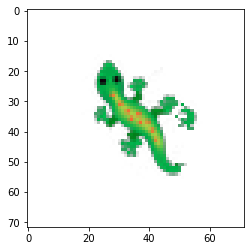

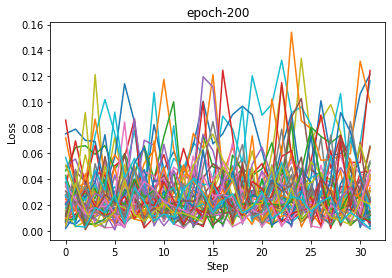

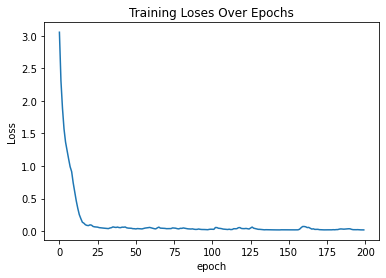

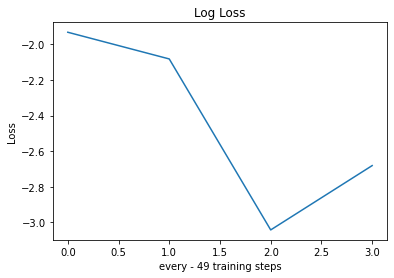



training epochs:  50%|█████     | 200/400 [50:05<1:21:26, 24.43s/it]

training epochs:  50%|█████     | 201/400 [50:19<1:10:53, 21.38s/it]

training epochs:  50%|█████     | 202/400 [50:33<1:03:31, 19.25s/it]

training epochs:  51%|█████     | 203/400 [50:47<58:22, 17.78s/it]  

training epochs:  51%|█████     | 204/400 [51:02<54:42, 16.75s/it]

training epochs:  51%|█████▏    | 205/400 [51:16<52:05, 16.03s/it]

training epochs:  52%|█████▏    | 206/400 [51:30<50:11, 15.52s/it]

training epochs:  52%|█████▏    | 207/400 [51:45<48:49, 15.18s/it]

training epochs:  52%|█████▏    | 208/400 [51:59<47:47, 14.93s/it]

training epochs:  52%|█████▏    | 209/400 [52:14<46:59, 14.76s/it]

training epochs:  52%|█████▎    | 210/400 [52:28<46:21, 14.64s/it]

training epochs:  53%|█████▎    | 211/400 [52:42<45:52, 14.56s/it]

training epochs:  53%|█████▎    | 212/400 [52:57<45:25, 14.50s/it]

training epochs:  53%|█████▎    | 213/400 [53:11<44:59, 14.44s/it]

training epochs:  54%|█████▎    | 214/



 LOSS: -1.3409805297851562


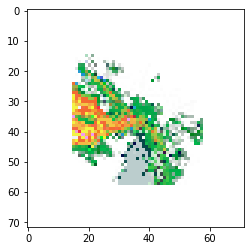

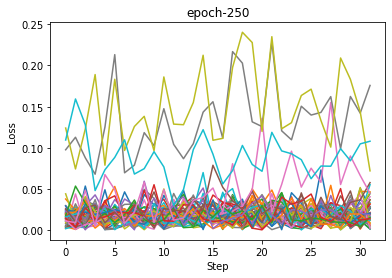

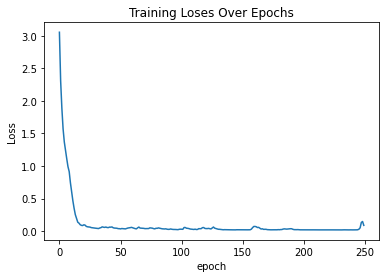

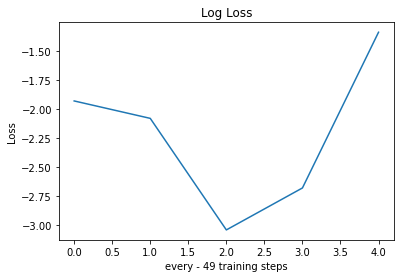



training epochs:  62%|██████▎   | 250/400 [1:02:39<1:04:20, 25.74s/it]

training epochs:  63%|██████▎   | 251/400 [1:02:53<55:22, 22.30s/it]  

training epochs:  63%|██████▎   | 252/400 [1:03:07<49:06, 19.91s/it]

training epochs:  63%|██████▎   | 253/400 [1:03:22<44:41, 18.24s/it]

training epochs:  64%|██████▎   | 254/400 [1:03:36<41:32, 17.07s/it]

training epochs:  64%|██████▍   | 255/400 [1:03:50<39:17, 16.26s/it]

training epochs:  64%|██████▍   | 256/400 [1:04:05<37:38, 15.69s/it]

training epochs:  64%|██████▍   | 257/400 [1:04:19<36:25, 15.28s/it]

training epochs:  64%|██████▍   | 258/400 [1:04:33<35:29, 14.99s/it]

training epochs:  65%|██████▍   | 259/400 [1:04:48<34:45, 14.79s/it]

training epochs:  65%|██████▌   | 260/400 [1:05:02<34:10, 14.64s/it]

training epochs:  65%|██████▌   | 261/400 [1:05:16<33:41, 14.54s/it]

training epochs:  66%|██████▌   | 262/400 [1:05:31<33:17, 14.47s/it]

training epochs:  66%|██████▌   | 263/400 [1:05:45<32:55, 14.42s/it]

training epoch



 LOSS: -2.8859686851501465


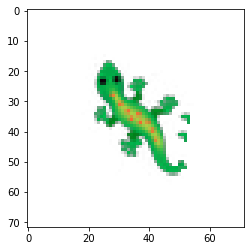

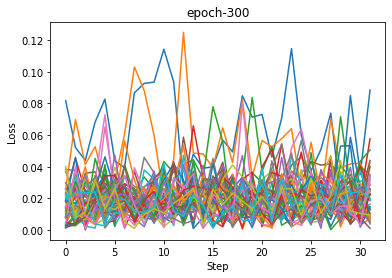

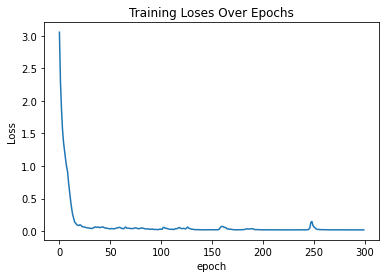

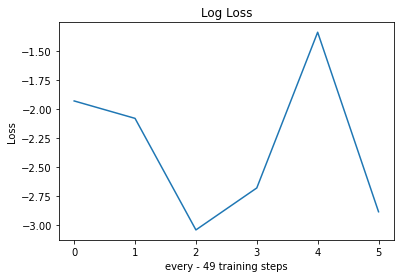



training epochs:  75%|███████▌  | 300/400 [1:15:08<40:59, 24.60s/it]

training epochs:  75%|███████▌  | 301/400 [1:15:23<35:29, 21.51s/it]

training epochs:  76%|███████▌  | 302/400 [1:15:37<31:36, 19.36s/it]

training epochs:  76%|███████▌  | 303/400 [1:15:51<28:51, 17.85s/it]

training epochs:  76%|███████▌  | 304/400 [1:16:06<26:52, 16.80s/it]

training epochs:  76%|███████▋  | 305/400 [1:16:20<25:25, 16.06s/it]

training epochs:  76%|███████▋  | 306/400 [1:16:34<24:20, 15.54s/it]

training epochs:  77%|███████▋  | 307/400 [1:16:49<23:30, 15.17s/it]

training epochs:  77%|███████▋  | 308/400 [1:17:03<22:51, 14.91s/it]

training epochs:  77%|███████▋  | 309/400 [1:17:17<22:20, 14.73s/it]

training epochs:  78%|███████▊  | 310/400 [1:17:31<21:53, 14.59s/it]

training epochs:  78%|███████▊  | 311/400 [1:17:46<21:31, 14.51s/it]

training epochs:  78%|███████▊  | 312/400 [1:18:00<21:10, 14.44s/it]

training epochs:  78%|███████▊  | 313/400 [1:18:14<20:52, 14.40s/it]

training epochs:  



 LOSS: -1.859857439994812


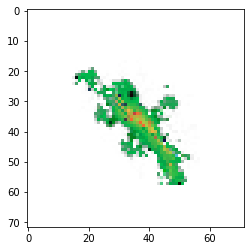

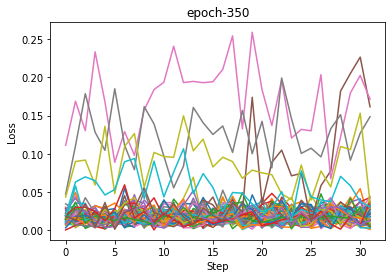

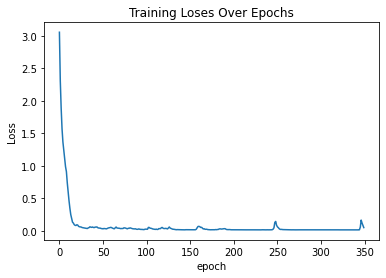

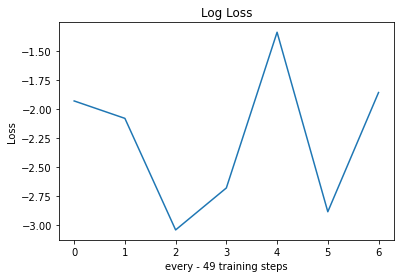



training epochs:  88%|████████▊ | 350/400 [1:27:40<20:53, 25.08s/it]

training epochs:  88%|████████▊ | 351/400 [1:27:54<17:49, 21.83s/it]

training epochs:  88%|████████▊ | 352/400 [1:28:08<15:40, 19.59s/it]

training epochs:  88%|████████▊ | 353/400 [1:28:23<14:07, 18.02s/it]

training epochs:  88%|████████▊ | 354/400 [1:28:37<12:58, 16.93s/it]

training epochs:  89%|████████▉ | 355/400 [1:28:52<12:07, 16.16s/it]

training epochs:  89%|████████▉ | 356/400 [1:29:06<11:26, 15.61s/it]

training epochs:  89%|████████▉ | 357/400 [1:29:20<10:54, 15.22s/it]

training epochs:  90%|████████▉ | 358/400 [1:29:35<10:27, 14.94s/it]

training epochs:  90%|████████▉ | 359/400 [1:29:49<10:04, 14.75s/it]

training epochs:  90%|█████████ | 360/400 [1:30:03<09:44, 14.62s/it]

training epochs:  90%|█████████ | 361/400 [1:30:17<09:26, 14.52s/it]

training epochs:  90%|█████████ | 362/400 [1:30:32<09:09, 14.46s/it]

training epochs:  91%|█████████ | 363/400 [1:30:46<08:53, 14.41s/it]

training epochs:  



 LOSS: -3.07704496383667


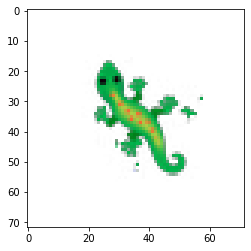

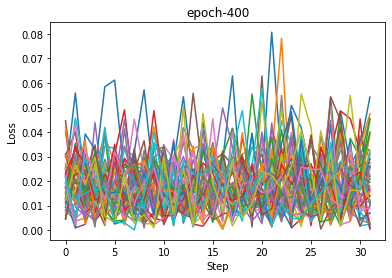

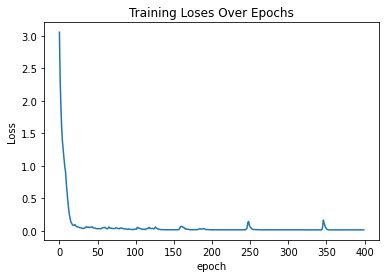

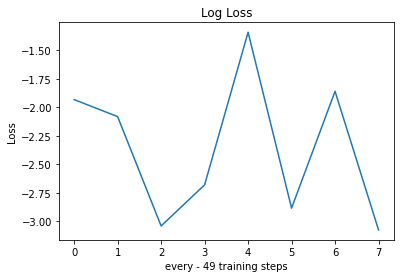



training epochs: 100%|██████████| 400/400 [1:40:12<00:00, 15.03s/it]


In [20]:
#@title Un-Ordered Training!!!!! { vertical-output: true}

# training
log_loss = []
SENTENCE_BATCH = 32
TRAIN_ON=True 
EVAL_STEPS = 21
EVAL_EVERY=50
VISUALISE_EVERY = 50

next_token_loss = [['EPOCH', 'STEP', 'LOSS']]
epoch_losses = []
epoch_mean_losses = []

training_dataset = create_training_dataset()
print('LEN DATASET', len(training_dataset))
data_loader = DataLoader(dataset=training_dataset, batch_size=64, shuffle=True)


for i in tqdm.tqdm(range(1,EPOCHS), mininterval=10., desc='training epochs'):
    if (TRAIN_ON):
      losses = []    
      enc.train(), dec.train()
      for batch_i , (src, tgt, src_mask, tgt_mask) in enumerate(data_loader):
        context = enc(src, input_mask = src_mask)
        loss = dec(tgt, context = context, input_mask = tgt_mask, context_mask = src_mask, return_loss = True)
        loss.backward()
        loss_value = loss.item()
        next_token_loss.append([i, batch_i, loss_value])
        losses.append(loss_value)
        optim.step()
        optim.zero_grad()

      epoch_mean_losses.append(sum(losses)/len(losses)  )
      epoch_losses.append(losses)

    # Generate:
    if (EVAL_STEPS > 0 and i % EVAL_EVERY == 0):
      x = get_X0()

      x = generate(enc, dec, x, EVAL_STEPS)

      npm = t_loss_f(x) #loss_f(x)
      loss_mean = np.mean(npm)
      lo_n = loss_mean
      lo_n = np.log10(lo_n)
      log_loss.append(lo_n)
      print(f'\n LOSS: {lo_n}')

    if (i % VISUALISE_EVERY == 0):
      visualize_batched(x.detach().clone())
      plt.figure()
      for ep, l in enumerate(epoch_losses):
        plt.plot(l, label=f'EPOCH-{i+ep}')

      plt.xlabel("Step")
      plt.ylabel("Loss")
      plt.title(f"epoch-{i}")
      # plt.legend()
      plt.show()
      epoch_losses = []

      plt.figure()
      plt.plot(epoch_mean_losses)

      plt.xlabel("epoch")
      plt.ylabel("Loss")
      plt.title(f"Training Loses Over Epochs")
      plt.show()

      if (len(log_loss) > 0):
        plt.figure()
        plt.plot(log_loss, label=f'EPOCH-{i+ep}')

        plt.xlabel(f"every - {EVAL_EVERY-1} training steps")
        plt.ylabel("Loss")
        plt.title("Log Loss")
        plt.show()

      
    # TODO - produced x - calculate l2 loss and add to log loss - need alignment first

In [24]:
#@title Save Models { vertical-output: true}
from datetime import datetime
current_t = datetime.now()
torch.save(enc, f'./enc-{str(current_t)}.pth')
torch.save(dec, f'./dec-{str(current_t)}.pth')

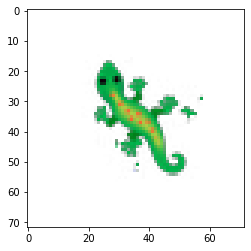

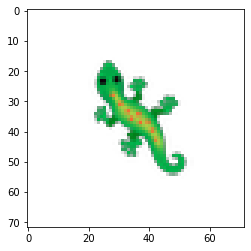

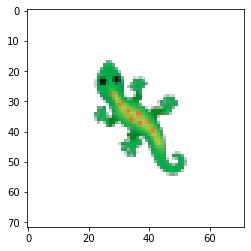

LOSS -4.3435802
TLOSS -3.077045
TLOSS CLEAN -4.3435802


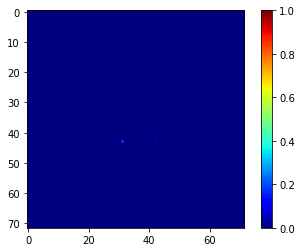

In [28]:

visualize_batched(x)

curr_mask = get_living_mask(x.float(), rate=0.1, k=1)

clean_mask = (loss_target_mask)

i_x = (x * clean_mask.float().bool().long()).long()

visualize_batched(pad_target[None,...].long())
visualize_batched(i_x)

to_test = i_x #i_x

# lxx  = loss_f(x)

lxx = torch.square((to_test/255.0)-loss_target).cpu().detach().numpy()
# print('lxx', lxx, lxx.shape)

lxx_m = np.mean(lxx, axis=1)
meaned_again = lxx_m.flatten()
# print('meaned again', meaned_again, meaned_again.shape)
meaned_again_2 = np.mean(meaned_again)
# print('meaned again 2', meaned_again_2, meaned_again_2.shape)

print('LOSS',  np.log10(meaned_again_2))
# print(torch.subtract(pad_target[:,40:50,30:40], x[0,:,40:50,30:40]))


# TODO get SHAPE VALUES MORE ACCURATLY.
img_loss = lxx_m.reshape(72,72)

plt.imshow(zoom(img_loss, 1), vmin=0, vmax=1, cmap='jet') #'gray_r'
plt.colorbar()



print('TLOSS', np.log10(np.mean(t_loss_f(x))) )
print('TLOSS CLEAN',np.log10(np.mean(t_loss_f(x, clean=True))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



-3.156209



-3.1545894



-3.0805504



-3.100915



-3.111835



-3.1544416



-3.1830523



-3.0968664



-3.1341877



-3.0936453



-3.0909004



-3.0800097



-3.3220065



-3.1189082



-3.0962713



-3.0609596



-3.2228217



-3.123995



-3.1309285



-4.6158404
-4.6158404


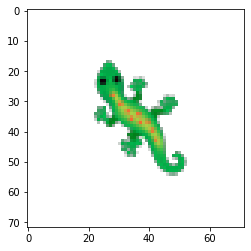

In [35]:
best_gen, best_score = None, float('inf')
for _ in range(20):
  x = generate(enc, dec, get_X0(), EVAL_STEPS)
  score = np.log10(np.mean(t_loss_f(x, clean=True)))
  if score  < best_score:
    best_score = score
    best_gen = x
  print(score)


print(best_score)
visualize_batched(cleaned_x_long(best_gen, loss_target_mask))